In [1]:
import json,os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def opt_density(dist,opt_type='max'):
    if opt_type=='max':
        opt_count = dist[np.argmax(dist[:,0]),1]
    else:
        opt_count = dist[np.argmin(dist[:,0]),1]
    feasible_count = np.sum(dist[:,1])
    rho = opt_count/feasible_count
    return rho

def poptUB(p,dist,opt_type='max'):
    rho = opt_density(dist,opt_type)
    return rho * (2*p+1)**2

def stdOverOptMinusMean(dist,opt_type='max'): # example: dist = np.array([[3,1],[1,49],[0,950]])
    dist_copy = dist.copy()
    if opt_type == 'max':
        opt = np.max(dist[:,0])
        dist_copy[np.argmax(dist[:,0]),1] = 0
    elif opt_type == 'min':
        opt = np.min(dist[:,0])
        dist_copy[np.argmin(dist[:,0]),1] = 0
    mean = np.sum(dist_copy[:, 0] * dist_copy[:, 1])/np.sum(dist_copy[:, 1])
    std = np.sqrt(np.sum(dist_copy[:, 1] * ((dist_copy[:, 0] - mean)**2))/np.sum(dist_copy[:, 1]))
    return std/np.abs(opt-mean)

In [3]:
def read_sampled_data(N_list, idx_list, p_list, get_path, get_path_th, get_path_dist, metric = 'max'):
        
    results = {'problem':[],'n':[],'depth':[],'popt':[],'use threshold-based strategy':[],'opt_density':[],'stdOverOptMinusMean':[],'poptBound':[]}

    for N in N_list:
        for idx in idx_list:
            for p in p_list:
                file_path = get_path(N,p,idx)
                if os.path.exists(file_path):
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                    results['problem'].append(f'n{N}_idx{idx}')
                    results['n'].append(N)
                    results['depth'].append(p)
                    results['popt'].append(data['p_opt'])
                    results['use threshold-based strategy'].append('False')
                    dist = np.load(get_path_dist(N, idx))
                    results['opt_density'].append(opt_density(dist,opt_type=metric))
                    results['poptBound'].append(poptUB(p,dist,opt_type=metric))
                    results['stdOverOptMinusMean'].append(stdOverOptMinusMean(dist,opt_type=metric))
                    if data['p_opt'] >= 0.99:
                        break
                else:
                    break
            for p in p_list:
                file_path = get_path_th(N,p,idx)
                if os.path.exists(file_path):
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                    results['problem'].append(f'n{N}_idx{idx}')
                    results['n'].append(N)
                    results['depth'].append(p)
                    results['popt'].append(data['p_opt'])
                    results['use threshold-based strategy'].append('True')
                    dist = np.load(get_path_dist(N, idx))
                    results['opt_density'].append(opt_density(dist,opt_type=metric))
                    results['poptBound'].append(poptUB(p,dist,opt_type=metric))
                    results['stdOverOptMinusMean'].append(0)
                    if data['p_opt'] >= 0.99:
                        break
                else:
                    break
                    
    df = pd.DataFrame(results)
    return df

In [4]:
def get_filelist(N_list, idx_list, p_list, get_path, get_path_th):
    
    filelist = []
    
    for N in N_list:
        for idx in idx_list:
            for p in p_list:
                file_path = get_path(N,p,idx)
                if os.path.exists(file_path):
                    filelist.append(file_path)
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                    if data['p_opt'] >= 0.99:
                        break
            for p in p_list:
                file_path = get_path_th(N,p,idx)
                if os.path.exists(file_path):
                    filelist.append(file_path)
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                    if data['p_opt'] >= 0.99:
                        break
                    
    return filelist

In [5]:
p_list = [i for i in range(1,100,2)]
idx_list = [i for i in range(48)]

In [6]:
N_list = [i for i in range(11,18)]
def get_path_dist(N,idx):
    return f'distribution/max_k_colorable/n{N}_k3/{idx}.npy'
def get_path(N,p,idx):
    return f'popt_result/max_k_colorable/n{N}_k3/p{p}/{idx}.json'
def get_path_th(N,p,idx):
    return f'popt_result/th/max_k_colorable/n{N}_k3/p{p}/{idx}.json'
df_sampled_mkcs = read_sampled_data(N_list, idx_list, p_list, get_path, get_path_th, get_path_dist)
df_sampled_mkcs['ratio'] = df_sampled_mkcs['popt']/df_sampled_mkcs['poptBound']

In [7]:
df_sampled_mkcs

,problem,n,depth,popt,use threshold-based strategy,opt_density,stdOverOptMinusMean,poptBound,ratio
0,n11_idx0,11,1,0.000392,False,6.774035e-05,0.308486,0.000610,0.642432
1,n11_idx0,11,3,0.001959,False,6.774035e-05,0.308486,0.003319,0.590223
2,n11_idx0,11,5,0.004797,False,6.774035e-05,0.308486,0.008197,0.585250
3,n11_idx0,11,7,0.008880,False,6.774035e-05,0.308486,0.015242,0.582626
4,n11_idx0,11,9,0.014200,False,6.774035e-05,0.308486,0.024454,0.580687
...,...,...,...,...,...,...,...,...,...
28623,n17_idx47,17,91,0.001555,True,4.646115e-08,0.000000,0.001556,0.999478
28624,n17_idx47,17,93,0.001624,True,4.646115e-08,0.000000,0.001625,0.999455
28625,n17_idx47,17,95,0.001694,True,4.646115e-08,0.000000,0.001695,0.999432
28626,n17_idx47,17,97,0.001766,True,4.646115e-08,0.000000,0.001767,0.999408


In [8]:
N_list = [n for n in range(18,31,2)]
def get_path_dist(N,idx):
    return f'distribution/max_k_vertex_cover/n{N}/{idx}.npy'
def get_path(N,p,idx):
    return f'popt_result/max_k_vertex_cover/n{N}/p{p}/{idx}.json'
def get_path_th(N,p,idx):
    return f'popt_result/th/max_k_vertex_cover/n{N}/p{p}/{idx}.json'
df_sampled_mkvc = read_sampled_data(N_list, idx_list, p_list, get_path, get_path_th, get_path_dist)
df_sampled_mkvc['ratio'] = df_sampled_mkvc['popt']/df_sampled_mkvc['poptBound']

In [9]:
N_list = [n for n in range(7,14)]
p_list = [i for i in range(1,10,2)]
def get_path_dist(N,idx):
    return f'distribution/tsp/n{N}/{idx}.npy'
def get_path(N,p,idx):
    return f'popt_result/tsp/n{N}/p{p}/{idx}.json'
def get_path_th(N,p,idx):
    return f'popt_result/th/tsp/n{N}/p{p}/{idx}.json'
df_sampled_tsp = read_sampled_data(N_list, idx_list, p_list, get_path, get_path_th, get_path_dist, metric = 'min')
df_sampled_tsp['ratio'] = df_sampled_tsp['popt']/df_sampled_tsp['poptBound']

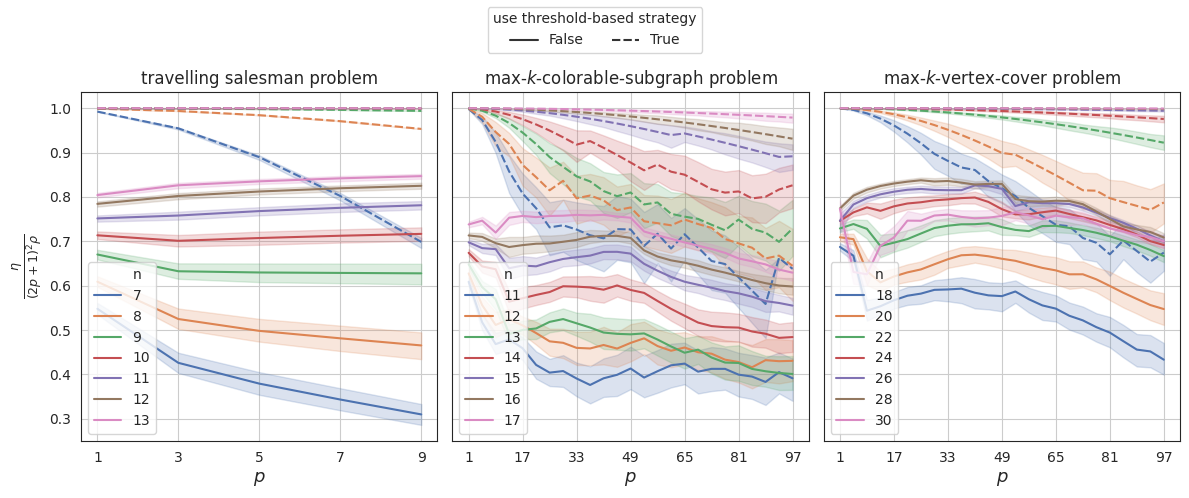

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
sns.set_style('white')

datasets = [df_sampled_tsp,df_sampled_mkcs, df_sampled_mkvc]
titles = ['travelling salesman problem',r'max-$k$-colorable-subgraph problem', r'max-$k$-vertex-cover problem']

for i, (data, title) in enumerate(zip(datasets, titles)):
    if i == 0:
        data = data[data['depth'] % 2 == 1]
    else:
        data = data[data['depth'] % 4 == 1]
    
    unique_N = data['n'].nunique()
    colors = sns.color_palette('deep',n_colors=unique_N)
    
    sns.lineplot(x='depth', y='ratio', data=data, hue='n', style='use threshold-based strategy', ax=axs[i], palette=colors)
    axs[i].set_xlabel(r"$p$", fontsize=13)
    axs[i].set_title(title)
    axs[i].grid()
    if i == 0:
        axs[i].set_xticks(range(1, 10, 2))
    else:
        axs[i].set_xticks(range(1, 100, 16))
    
axs[0].set_ylabel(r"$\frac{\eta}{(2p+1)^2 \rho}$", fontsize=13)

for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:-3], labels[:-3], loc='lower left')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[-2:], labels[-2:], loc='upper center', ncol=3, title='use threshold-based strategy')

plt.tight_layout(rect=[0, 0, 1, 0.9]) 
plt.savefig('./figs/popt_ratio.pdf')
plt.show()